# Node classfication

In [1]:
cd ~/thesis

/home/jovyan/thesis


/home/jovyan/venvs/my_environment/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/jovyan/venvs/my_environment/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Import libraries

In [2]:
import numpy as np
import pandas as pd
import networkx as nx

# Modify eliorc's implementation
from eliorc_mod.node2vec import Node2Vec
from gensim.models import Word2Vec

from utils import model_gen, plot_graph, relabel_subgraph, \
enhanced_ext_subgraph_func, connect_subgraph, groups_assign, \
emb_group_gen, ovr_classifier, get_neighborhood, \
remove_nodes_connected, generate_extended_embeddings, compare_models

/tmp/ipykernel_290/3219661849.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### BlogCatalog 

In [4]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

# Groups mapping
group_df = pd.read_csv(blog_dir+'group-edges.csv', delimiter=',')
group_df.columns = ['node_num', 'group']

model = Word2Vec.load("models/blog_model")

groups_dict = {node_num: group_df.loc[node_num, 'group']  for node_num in group_df['node_num']}

X, y, _ = emb_group_gen(groups_dict, model)


# # Plot
# test_grid_search(G, X, y)

## Adding/removing nodes/edges

### Extending

#### Stochastic Block Model

In [6]:
sizes = [200, 100, 150]

probs = [[0.01, 0.025, 0.02],
         [0.025, 0.05, 0.02],
         [0.02, 0.02, 0.01]]

initial_graph = nx.stochastic_block_model(sizes, probs, seed=0)
# initial_graph.remove_nodes_from([0, 4])

In [9]:
ext_subgraph = nx.erdos_renyi_graph(n=125, p=0.45, seed=12)

# Relabel the subgraph based on the initial graph
ext_subgraph = relabel_subgraph(initial_graph, ext_subgraph)

In [10]:
compare_models(initial_graph, ext_subgraph)

New graph (from scratch)
For training size: 0.9: [[0.25862068965517243, 0.24764189215802118]]
For training size: 0.8: [[0.1826086956521739, 0.18300978928156628]]
For training size: 0.7: [[0.23121387283236994, 0.23017435810169581]]
For training size: 0.6: [[0.20869565217391303, 0.20771250984104225]]
For training size: 0.5: [[0.21875, 0.21909433025297834]]
For training size: 0.4: [[0.22028985507246376, 0.22105905977239457]]
For training size: 0.29999999999999993: [[0.23325062034739455, 0.23193697769926977]]
For training size: 0.19999999999999996: [[0.2217391304347826, 0.2208709477056816]]
For training size: 0.09999999999999998: [[0.20656370656370657, 0.19793177814738688]]



Manually updated graph (extending the graph)
For training size: 0.9: [[0.20689655172413793, 0.19622728318380492]]
For training size: 0.8: [[0.21739130434782608, 0.21445698372219896]]
For training size: 0.7: [[0.1791907514450867, 0.17744530399180722]]
For training size: 0.6: [[0.23478260869565218, 0.23237556464735598]

In [45]:
# ext_subgraph = relabel_subgraph(initial_graph, ext_subgraph)

# [node_main, node_sub], mod_graph = connect_subgraph(initial_graph, ext_subgraph)

# print(f'Main node: {node_main}')
# print(f'Sub node: {node_sub}')

In [46]:
# list(initial_graph.neighbors(node_main))

In [47]:
# len(list(get_neighborhood(initial_graph, 2, 1).nodes()))

In [51]:
# enh_ext_subgraph = enhanced_ext_subgraph_func(initial_graph, ext_subgraph, node_main, max_step=2)

In [25]:
# plot_graph(ext_subgraph)

In [26]:
# plot_graph(enh_ext_subgraph)

In [27]:
# print(f'Extending subgraph nodes: {sorted(ext_subgraph.nodes())}')
# print(f'Enhanced extending subgraph nodes: {sorted(enh_ext_subgraph.nodes())}')

In [28]:
# len(initial_graph.nodes()), len(initial_graph.edges())
# len(ext_subgraph.nodes()), len(ext_subgraph.edges())
# len(enh_ext_subgraph.nodes()), len(enh_ext_subgraph.edges())
# len(mod_graph.nodes()), len(mod_graph.edges())

In [10]:
# params = [64, 10, 80, 0.25, 4]

# groups_dict = groups_assign(initial_graph, relabel_subgraph(initial_graph, ext_subgraph))

# X_ext, y_ext = generate_extended_embeddings(initial_graph, ext_subgraph, params, groups_dict)

# [node_main, node_sub], mod_graph = connect_subgraph(initial_graph, ext_subgraph)
# enh_ext_subgraph = enhanced_ext_subgraph_func(initial_graph, ext_subgraph, node_main, max_step=2)

# node2vec_initial, model_initial = model_gen(initial_graph, params)
# node2vec_ext, model_ext = model_gen(enh_ext_subgraph, params)
# node2vec_mod, model_mod = model_gen(mod_graph, params)

Manually

In [34]:
# node2vec_ext, model_ext = model_gen(ext_subgraph, params)
# model_ext.wv.vectors.shape

node2vec_initial, model_initial = model_gen(initial_graph, params)
node2vec_ext, model_ext = model_gen(enh_ext_subgraph, params)
node2vec_mod, model_mod = model_gen(mod_graph, params)

In [131]:
X_initial, y_initial, node_vectors_dict_initial = emb_group_gen(groups_dict, model_initial)

In [132]:
X_ext, y_ext, node_vectors_dict_ext = emb_group_gen(groups_dict, model_ext)

In [133]:
X_mod, y_mod, node_vectors_dict_mod = emb_group_gen(groups_dict, model_mod)

In [134]:
kept_nodes = set(enh_ext_subgraph.nodes()) - set(node_vectors_dict_initial.keys()).intersection(enh_ext_subgraph.nodes())

In [135]:
X_ext_only = [node_vectors_dict_ext[node] for node in kept_nodes]
y_ext_only = [groups_dict[node] for node in kept_nodes]

In [136]:
X_manual = X_initial + X_ext_only
y_manual = y_initial + y_ext_only

In [137]:
len(X_initial), len(X_mod), len(X_manual)

(300, 375, 375)

In [138]:
test_sizes = np.arange(0.1, 1, 0.1)
test_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [139]:
print("New graph (from scratch)")
for test_size in test_sizes:
    print(f"For training size: {(1-test_size)}: {list(ovr_classifier(X_mod, y_mod, test_size).values())}")

print(2*'\n')

print("Manually updated graph (extending the graph)")
for test_size in test_sizes:
    print(f"For training size: {(1-test_size)}: {list(ovr_classifier(X_manual, y_manual, test_size).values())}")

New graph (from scratch)
For training size: 0.9: [[0.21052631578947367, 0.2333333333333334]]
For training size: 0.8: [[0.21333333333333335, 0.21445328014725668]]
For training size: 0.7: [[0.1415929203539823, 0.1414285714285714]]
For training size: 0.6: [[0.15333333333333332, 0.1493379933459694]]
For training size: 0.5: [[0.19680851063829788, 0.19943981758393306]]
For training size: 0.4: [[0.2, 0.20337840721088768]]
For training size: 0.29999999999999993: [[0.20152091254752852, 0.19793567543567545]]
For training size: 0.19999999999999996: [[0.18666666666666668, 0.18308305067570002]]
For training size: 0.09999999999999998: [[0.20414201183431951, 0.19568052997006866]]



Manually updated graph (extending the graph)
For training size: 0.9: [[0.13157894736842105, 0.13968253968253969]]
For training size: 0.8: [[0.10666666666666667, 0.1066025641025641]]
For training size: 0.7: [[0.13274336283185842, 0.1281740774948322]]
For training size: 0.6: [[0.11333333333333333, 0.10787598874555396]]
For 

In [108]:
# test_grid_search(mod_graph, X_fast, y_fast)
# test_grid_search(mod_graph, X_mod, y_mod)

#### BlogCatalog

In [3]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

initial_graph = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
initial_graph.name = 'blog_catalog'

# Groups mapping
group_df = pd.read_csv(blog_dir+'group-edges.csv', delimiter=',')
group_df.columns = ['node_num', 'group']

model = Word2Vec.load("models/blog_model")

In [4]:
ext_subgraph = nx.erdos_renyi_graph(n=75, p=0.35, seed=12)

# Relabel the subgraph based on the initial graph
ext_subgraph = relabel_subgraph(initial_graph, ext_subgraph)

compare_models(initial_graph, ext_subgraph)


KeyboardInterrupt



In [28]:
# Fill these similar to previous cells - make a function

In [ ]:
params = [64, 10, 80, 0.25, 4]

In [ ]:
groups_dict = groups_assign(initial_graph, ext_subgraph)

# Generate embeddings for the extending subgraph, without common embeddings with initial graph
X_ext, y_ext = generate_extended_embeddings(initial_graph, ext_subgraph, params, groups_dict)

## Finding nearby area of node

In [29]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

# plt.figure(figsize=(3, 3))
# nx.draw(G, with_labels=True)
# plt.show()

In [32]:
len(get_neighborhood(G, '1', 1).nodes())

119

In [33]:
len(get_neighborhood(G, '1', 2).nodes())

9554

In [34]:
G = nx.random_regular_graph(3, 40, seed=10)

# plt.figure(figsize=(3, 3))
# nx.draw(G, with_labels=True)
# plt.show()

In [35]:
list(get_neighborhood(G, 0, 1))

[25, 4, 15]

In [36]:
list(get_neighborhood(G, 0, 3))

[33, 34, 4, 36, 6, 7, 37, 38, 14, 15, 16, 18, 22, 25, 27, 28, 29, 31]

### Pruning

#### BlogCatalog

In [37]:
blog_dir = '/home/jovyan/thesis/datasets/blog_catalog/data/'

# blog_dir = 'datasets/blog_catalog/data/'

G = nx.read_edgelist(blog_dir+'edges.csv', delimiter=',')
G.name = 'blog_catalog'

#### Other graphs

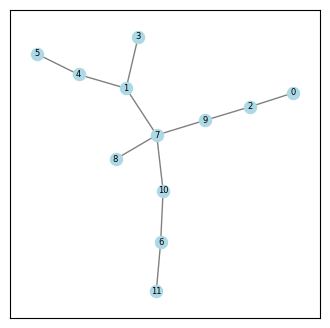

In [11]:
G = nx.random_tree(12, seed=1)

plot_graph(G)

In [12]:
graph, removed_nodes = remove_nodes_connected(G, 3)
removed_nodes

[0, 11, 3]

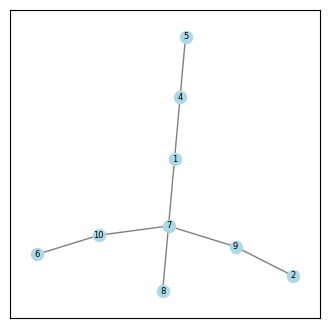

In [14]:
plot_graph(graph)

In [15]:
neighbors = []

for node in removed_nodes: 
    neighbors += list(get_neighborhood(G, node, 2))

In [16]:
neighbors

[9, 2, 10, 6, 1, 4, 7]

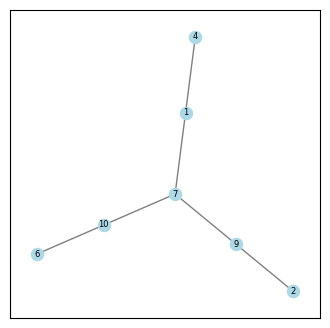

In [17]:
plot_graph(G.subgraph(neighbors))

In [18]:
removed_nodes

[0, 11, 3]

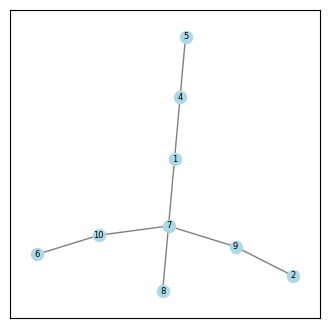

In [20]:
plot_graph(graph)

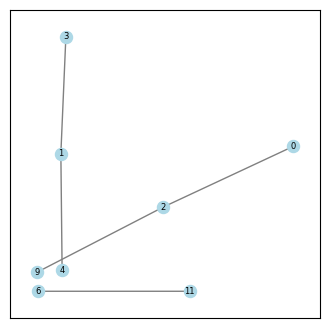

In [21]:
plot_graph(G.subgraph([0, 2, 9, 6, 11, 3, 1, 4]))

In [51]:
# This works even if the graph is not connected
# Node2Vec(G.subgraph([0, 2, 9, 6, 11, 3, 1, 4]))

In [52]:
sizes = [10, 10, 25]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]

G = nx.stochastic_block_model(sizes, probs, seed=0)

## Testing Wikipedia .mat file

In [ ]:
data = scipy.io.loadmat('datasets/wikipedia/POS.mat')

matrix0 = data['network'].astype('float32')

In [ ]:
data

In [ ]:
data['group']

In [ ]:
data['group'].toarray()

In [ ]:
matrix0

In [ ]:
4777**2

## Graph customisation

NameError: name 'initial_graph' is not defined